## Notebook example of ptychograpic reconstruction on simulated data

This is a basic example, showing how to:
* simulate data
* compute the object shape from the data
* use the Ptycho operators for reconstruction

In [1]:
# Optional: select language and/or GPU name or rank through environment variable
#import os
#os.environ['PYNX_PU'] = 'cuda'

%matplotlib widget
import matplotlib.pyplot as plt
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

## Simulate the Ptychography dataset

In [2]:
# 2D detector size (square)
nxy = 256
# Pixel size in meters
pixel_size_detector = 55e-6
# Wavelength in meters
wavelength = 1.5e-10
# Detector distance in meters
detector_distance = 1

# Object options 'siemens' simulates Siemens star (with a few holes)
# 'logo' simulates PyNX logo
# obj_info = {'type': 'logo', 'phase_stretch': 1.57, 'alpha_win': .2}
obj_info = {'type': 'siemens', 'phase_stretch': 1.57, 'alpha_win': .2}

# Probe description, either as a Gaussian, or as a focused aperture
probe_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 350e-6, 'shape': (nxy, nxy)}
# probe_info = {'type': 'gauss', 'sigma_pix': (20, 20), 'shape': (nxy, nxy)}

# Spiral scan: 50 positions = 4 turns, 78 = 5 turns, 113 = 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200}

if False:
    # Use last frame without sample (direct beam ; serves as an absolute reference)
    s = simulation.Simulation(obj_info=None, probe_info=None, scan_info=scan_info, data_info=None, verbose=False)
    s.make_scan()
    posx, posy = s.scan.values
    posx[-1] = 1e20
    posy[-1] = 1e20
    posx = np.ma.masked_array(posx, posx>=1e10)
    posy = np.ma.masked_array(posy, posy>=1e10)
    scan_info = {'type': 'custom', 'x': posx, 'y': posy}

# Data info, with the different parameters and using Poisson noise
# nb_photons_per_frame is the average number of photons per frame
data_info = {'nb_photons_per_frame': 1e9, 'bg': 0, 'wavelength': wavelength,
             'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector,
             'noise': 'poisson'}

# Initialisation of the simulation
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s.make_data()
posx, posy = s.scan.values
pixel_size_object = wavelength * detector_distance / pixel_size_detector / nxy
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity


Simulating object: siemens
Simulating probe: focus
Simulating scan: spiral
Simulating ptychographic data [200 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': None, 'nb_photons_per_frame': 1000000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 5.5e-05}
Scan info: {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200, 'integer_values': False}
Object info: {'type': 'Custom', 'phase_stretch': 1.57, 'alpha_win': 0.2}
Probe info: {'type': 'focus', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (0.00015, 0.00015), 'focal_length': 0.08, 'defocus': 0.00035}


## Prepare the initial object and probe
This uses the `pynx.ptycho.simulation` module for an explicit simulation of object and probe.

Note that if the initial object array is not supplied to the `Ptycho`object (`obj=None`), its size will be automatically calculated, and the object initialised to an homogeneous object (array of 1)

In [3]:
# Size of the reconstructed object
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
obj_init_info = {'type': 'random', 'range': (0.9, 1, 0, 0.5), 'shape': (nyo, nxo)}

# Initial probe
probe_init_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 250e-6, 'shape': (nxy, nxy)}

# Basic data info, used to compute the object pixel size
data_info = {'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector}
# Perform the actual simulation
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)
init.make_obj()
init.make_probe()

Simulating object: random
Simulating probe: focus


## Create the `PtychoData` and `Ptycho` objects

In [4]:
data = PtychoData(iobs=ampl ** 2, positions=(posx * pixel_size_object, posy * pixel_size_object), 
                  detector_distance=1, mask=None, pixel_size_detector=55e-6, wavelength=1.5e-10)

# Random object start
p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None) 

# Initial scaling of object and probe
p = ScaleObjProbe(verbose=True) * p

ScaleObjProbe: 3191.7012 328442.88 3427.582777789404 593.8992700602388 5.771320058379261


## Optimise the Ptycho object 
This can use different algorithms:
* Difference Map
* Alternating Projections
* Maximum Likelihood conjugate gradient

For each algorithm it is possible to update object, probe, positions, and to display the result.

Each algorithm operator is elevated to the the number of cycles, e.g. `DM()**40` will perform 40 cycles

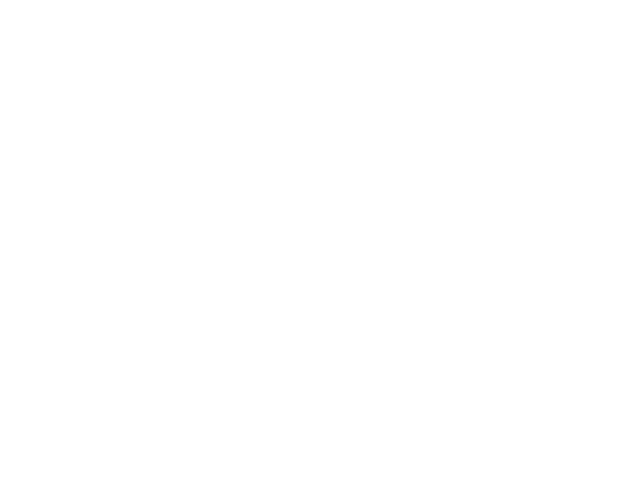

In [5]:
# Open the figure first so it is live-updated
fig = plt.figure()

In [6]:
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p
#p = ShowObjProbe() * AP(update_object=True, update_probe=False, calc_llk=10)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p

DM/o/p     #  0 LLK= 115035.39(p) 191011.62(g) 122742.17(e), nb photons=2.600464e+12, dt/cycle= 3.9437s
DM/o/p     # 20 LLK=  1164.33(p)  1332.26(g)  1686.60(e), nb photons=2.584566e+12, dt/cycle= 0.0375s
DM/o/p     # 40 LLK=    19.78(p)    33.27(g)    36.20(e), nb photons=2.599904e+12, dt/cycle= 0.0356s
DM/o/p     # 60 LLK=     1.57(p)     3.13(g)     3.13(e), nb photons=2.600445e+12, dt/cycle= 0.0368s
DM/o/p     # 80 LLK=     0.83(p)     1.66(g)     1.66(e), nb photons=2.600450e+12, dt/cycle= 0.0383s
DM/o/p     # 99 LLK=     0.60(p)     1.19(g)     1.19(e), nb photons=2.600450e+12, dt/cycle= 0.0431s
ML/o/p     #100 LLK=     0.59(p)     1.18(g)     1.18(e), nb photons=2.600464e+12, dt/cycle= 0.4425s
ML/o/p     #120 LLK=     0.58(p)     1.15(g)     1.15(e), nb photons=2.600460e+12, dt/cycle= 0.0893s
ML/o/p     #140 LLK=     0.58(p)     1.14(g)     1.15(e), nb photons=2.600465e+12, dt/cycle= 0.0921s
ML/o/p     #160 LLK=     0.57(p)     1.14(g)     1.14(e), nb photons=2.600457e+12, dt/cy

## Use DM and ML options to smooth the object and/or probe
For DM or AP, use the `*_smooth_sigma` and `*_inertia` parameters
For ML, use the `reg_fac_*` parameters.

Note that this does does not 'smooth' the object significantly unless you use large values.
What this actually does is tell the algorithm to keep the object/probe close to a smoothed
version of the previous iteration, while being also constrained to the observed data.

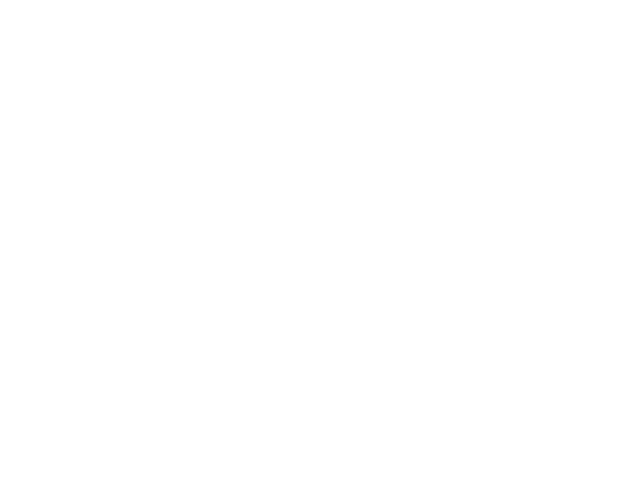

In [7]:
fig = plt.figure()  # Create a new figure instead of using the one in cell above

In [8]:
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20,
       obj_smooth_sigma=0.1, obj_inertia=0.01, probe_smooth_sigma=0.05, probe_inertia=0.001)**40 * p

p = ML(update_object=True, update_probe=True, show_obj_probe=20,
       calc_llk=20, reg_fac_obj=0.01, reg_fac_probe=0)**100 * p


DM/o/p     #200 LLK=     0.57(p)     1.13(g)     1.13(e), nb photons=2.600468e+12, dt/cycle= 8.7992s
DM/o/p     #220 LLK=     0.52(p)     1.03(g)     1.03(e), nb photons=2.600455e+12, dt/cycle= 0.0403s
DM/o/p     #239 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600451e+12, dt/cycle= 0.0414s
ML/o/p     #240 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600464e+12, dt/cycle= 0.4614s
ML/o/p     #260 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600460e+12, dt/cycle= 0.0853s
ML/o/p     #280 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600460e+12, dt/cycle= 0.0866s
ML/o/p     #300 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600460e+12, dt/cycle= 0.0894s
ML/o/p     #320 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600460e+12, dt/cycle= 0.0898s
ML/o/p     #339 LLK=     0.51(p)     1.01(g)     1.01(e), nb photons=2.600460e+12, dt/cycle= 0.0945s


## Add probe modes and continue optimising
The `DM/o/3p` indicates:
* the algorithm (DM or AP or ML)
* the parts which are optimised (o for object, p for probe, t for translations)
* the number of modes (when >1)

(in this case with simulated data, the additional probe modes are not useful)

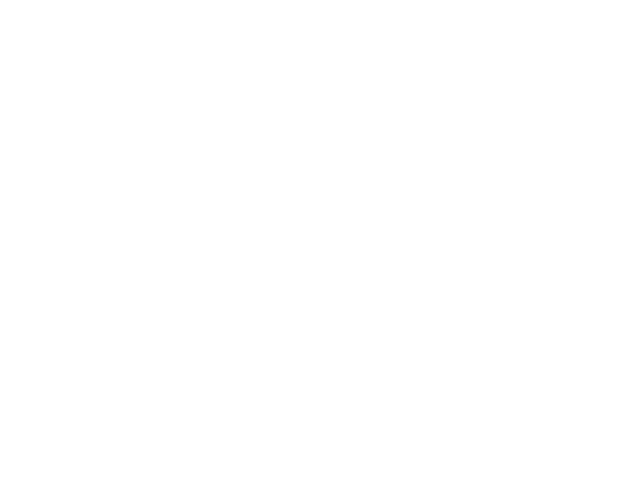

In [9]:
fig = plt.figure()

In [10]:
pr = p.get_probe()
nb_probe, ny, nx = pr.shape
# New number of probe modes
nb_probe = 3 
pr1 = np.empty((nb_probe, ny, nx), dtype=np.complex64)
pr1[0] = pr[0]
for i in range(1, nb_probe):
    n = abs(pr).mean() / 10
    pr1[i] = np.random.uniform(0, n, (ny, nx)) * np.exp(1j * np.random.uniform(0,2*np.pi, (ny,nx)))

p.set_probe(pr1)

p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p


DM/o/3p    #340 LLK=    25.58(p)   194.41(g)    59.10(e), nb photons=2.603690e+12, dt/cycle=19.5591s
DM/o/3p    #360 LLK=     0.51(p)     1.02(g)     1.02(e), nb photons=2.600458e+12, dt/cycle= 0.0551s
DM/o/3p    #379 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600453e+12, dt/cycle= 0.0626s
ML/o/3p    #380 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600463e+12, dt/cycle= 0.5306s
ML/o/3p    #400 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600459e+12, dt/cycle= 0.1276s
ML/o/3p    #420 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600459e+12, dt/cycle= 0.1293s
ML/o/3p    #440 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600459e+12, dt/cycle= 0.1361s
ML/o/3p    #460 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600459e+12, dt/cycle= 0.1388s
ML/o/3p    #479 LLK=     0.50(p)     1.00(g)     1.00(e), nb photons=2.600459e+12, dt/cycle= 0.1369s


In [13]:
# Manual decompositon of algorithms
#p = Psi2Obj() * PropagateApplyAmplitude()* ObjProbe2Psi() * SelectStack(0) * p
#p = Psi2ObjMerge() * LoopStack(Psi2Obj() * PropagateApplyAmplitude() * ObjProbe2Psi()) * p

## Export data and/or result object & probe to CXI (hdf5) files

In [9]:
if False:
    # 
    p.save_obj_probe_cxi('obj_probe.cxi')
    save_ptycho_data_cxi('data.cxi', ampl ** 2, pixel_size_detector, wavelength, detector_distance,
                         posx * pixel_size_object, posy * pixel_size_object, z=None, monitor=None,
                         mask=None, instrument='simulation', overwrite=True)
